# IIR滤波器系数的优化方法
## 直接一型与直接二型均适用

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal


In [ ]:
# 计算给定截止频率比例和系数量化位宽下的滤波器量化误差(系数的量化误差会随频率变化而变化)
def calc_quant_error(fc_fs_ratio, fs=10000, btype='low',
                     b_bit=20, a_bit=19, signal_range=16384, verbose=False):
    """
    计算给定截止频率比例和系数量化位宽下的滤波器量化误差

    参数
    ----
    fc_fs_ratio : float
        截止频率与采样率之比 (fc / fs)
    fs : float, optional
        采样率（默认 10000）
    btype : str, optional
        滤波器类型 ('low', 'high', 'bandpass', 'bandstop')
    b_bit : int, optional
        分子 (b) 量化位宽
    a_bit : int, optional
        分母 (a) 量化位宽
    signal_range : float, optional
        输入信号量程（用于放大误差）

    返回
    ----
    quant_err : float
        最大幅频响应误差对应的量化误差
    """

    # 计算截止频率
    fc = fc_fs_ratio * fs

    # 设计二阶巴特沃斯滤波器
    b, a = signal.butter(2, fc / (fs / 2), btype=btype)

    # 定点量化
    quant_b_scale = 2 ** b_bit
    quant_a_scale = 2 ** a_bit
    b_q = np.round(b * quant_b_scale) / quant_b_scale
    a_q = np.round(a * quant_a_scale) / quant_a_scale
    # print(b_q * quant_b_scale, a_q * quant_b_scale)

    # 计算频率响应
    w, h = signal.freqz(b, a)
    w_q, h_q = signal.freqz(b_q, a_q)

    # 量化误差（取最大响应差 × 信号幅度）
    quant_err = signal_range * np.max(np.abs(h - h_q))
    # plt.plot(w / np.pi, signal_range*np.abs(h-h_q), label='Original')
    if verbose:
        print("quant_err close pole point: ", quant_err)
    return quant_err

quant_err close pole point:  717.6077631469175


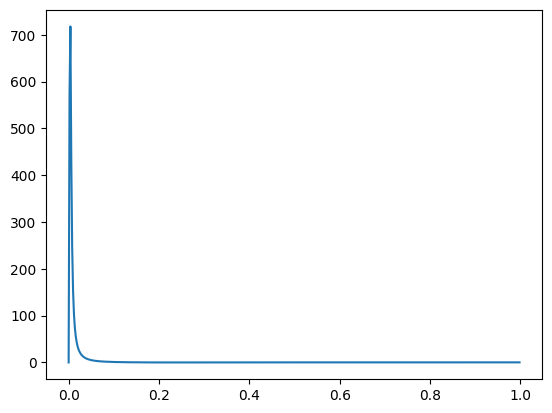

In [3]:
fc_fs_ratio = 0.002
iir_coeff_bit = 15
err = calc_quant_error(fc_fs_ratio, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit,
                         signal_range=32767, verbose=True)

In [4]:
# 根据系数量化前后，幅频响应的差值(量化误差)，在目标区间内 [0.95*fs, 1.05*fs]搜寻量化误差最小的滤波器系数
def search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=10000, signal_range=16384):
    """
    输入：
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        search_range: 在 fc_fs_ratio 的基础上搜索的范围(1-search_range)*fc_fs_ratio,  (1+search_range) * fc_fs_ratio
        fs: 采样率(默认10000)
    """
    # 根据fc/fs, 搭建搜寻空间
    start_fc_fs_ratio = fc_fs_ratio * (1 - search_range)
    end_fc_fs_ratio = fc_fs_ratio * (1 + search_range)
    step = 1e-6
    fc_fs_ratio_list = [start_fc_fs_ratio + i * step for i in range(int(search_range*2*fc_fs_ratio/step))]
    fc_fs_ratio_dict = {} # fc_fs_ratio -> delta_error

    for fc_fs_ratio in fc_fs_ratio_list:
        fc_fs_ratio_dict[fc_fs_ratio] = calc_quant_error(fc_fs_ratio, fs=fs, btype='low', b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=False)
    
    best_fc_fs_ratio = min(fc_fs_ratio_dict, key=fc_fs_ratio_dict.get)
    # print("best_fc_fs_ratio: ", best_fc_fs_ratio)
    # print("b a coeffs err: ", fc_fs_ratio_b_a_dict[best_fc_fs_ratio])

    return best_fc_fs_ratio, fc_fs_ratio_dict[best_fc_fs_ratio]

In [5]:
# 根据fc/fs, 得到b0 b1 b2 a1 a2系数
def get_quant_coeff(fc_fs_ratio, fs=10000, dec_bit=15):
    fc = fc_fs_ratio * fs

    # 设计二阶巴特沃斯滤波器
    b, a = signal.butter(2, fc / (fs / 2), btype='low')

    # 定点量化
    quant_scale = 2 ** dec_bit
    b_q = np.round(b * quant_scale).astype("int32")
    a_q = np.round(a * quant_scale).astype("int32")
    # print(b_q, a_q)
    return [b_q[0], b_q[1], b_q[2], -a_q[1], a_q[2]]

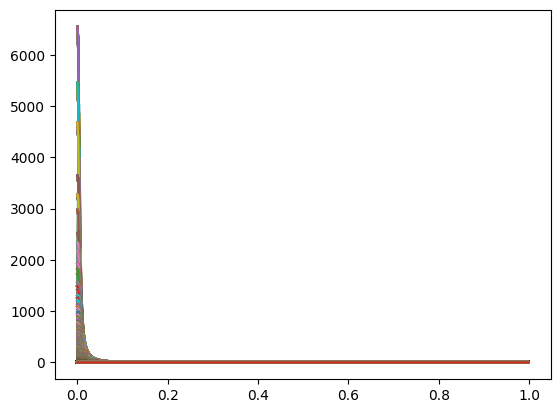

In [6]:
fc_fs_ratio_lists = np.concatenate([
    np.arange(0.002, 0.01, 0.00025),    # 0.002-0.01, 间隔0.001
    np.arange(0.01, 0.05, 0.001),     # 0.01-0.05, 间隔0.002
    np.arange(0.05, 0.26, 0.01)       # 0.05-0.25, 间隔0.01
]).tolist()
iir_coeff_bit = 15      # 15 bit的小数位
signal_range = 32768
search_range = 0.05     # [0.95*fc/fs, 1.05*fc/fs]
fs = 10000

new_fc_fs_quant_eoff = {}
for fc_fs_ratio in fc_fs_ratio_lists:
    new_fc_fs_ratio, new_quant_err = search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range, fs, signal_range=32768)
    new_fc_fs_quant_eoff[fc_fs_ratio] = [get_quant_coeff(new_fc_fs_ratio), round(new_quant_err, 2), new_fc_fs_ratio]

# print(new_fc_fs_quant_eoff)

In [8]:
from tabulate import tabulate
table_data = []
for fc_fs, (coefficients, quant_error, new_fc_fs) in new_fc_fs_quant_eoff.items():
    b0, b1, b2, a1, a2 = coefficients
    table_data.append([
        f"{fc_fs:.5f}",  # fc/fs 格式化为3位小数
        f"{new_fc_fs:.10f}", # 优化后 fc/fs 格式化为10位小数
        f"{b0:d}",       # b0 整数格式
        f"{b1:d}",       # b1 整数格式  
        f"{b2:d}",       # b2 整数格式
        f"{a1:d}",       # a1 整数格式
        f"{a2:d}",       # a2 整数格式
        f"{quant_error:.2f}",  # 量化误差格式化为2位小数
        
    ])

# 定义表头
headers = ['fc/fs', '优化后fc/fs', 'b0', 'b1', 'b2', 'a1', 'a2', '系数量化误差']

# 打印表格
print(tabulate(table_data, headers=headers))

  fc/fs    优化后fc/fs    b0     b1    b2     a1     a2    系数量化误差
-------  -------------  ----  -----  ----  -----  -----  --------------
0.002        0.001975      1      3     1  64961  32198            9.98
0.00225      0.0023375     2      3     2  64855  32094           10.06
0.0025       0.002501      2      4     2  64808  32048            5.21
0.00275      0.0026535     2      5     2  64763  32004           21.08
0.003        0.003066      3      6     3  64643  31887            5.11
0.00325      0.0031935     3      7     3  64606  31851           23.37
0.0035       0.003431      4      7     4  64537  31784            1.13
0.00375      0.0036545     4      9     4  64472  31721            0.48
0.004        0.003966      5     10     5  64381  31633            4.71
0.00425      0.0043485     6     12     6  64270  31526            4.03
0.0045       0.004349      6     12     6  64270  31526            1.58
0.00475      0.0049485     8     15     8  64095  31358            3.72
0

In [ ]:
  fc/fs    优化后fc/fs    b0     b1    b2     a1     a2    系数量化误差
-------  -------------  ----  -----  ----  -----  -----  --------------
0.002        0.001975      1      3     1  64961  32198            9.98
0.00225      0.0023375     2      3     2  64855  32094           10.06
0.0025       0.002501      2      4     2  64808  32048            5.21
0.00275      0.0026535     2      5     2  64763  32004           21.08
0.003        0.003066      3      6     3  64643  31887            5.11
0.00325      0.0031935     3      7     3  64606  31851           23.37
0.0035       0.003431      4      7     4  64537  31784            1.13
0.00375      0.0036545     4      9     4  64472  31721            0.48
0.004        0.003966      5     10     5  64381  31633            4.71
0.00425      0.0043485     6     12     6  64270  31526            4.03
0.0045       0.004349      6     12     6  64270  31526            1.58
0.00475      0.0049485     8     15     8  64095  31358            3.72
0.005        0.004785      7     15     7  64143  31404            0.51
0.00525      0.0053375     9     18     9  63982  31250            1.51
0.0055       0.00563      10     20    10  63897  31169            0.48
0.00575      0.0059085    11     22    11  63816  31092            0.88
0.006        0.00584      11     21    11  63836  31111            1.08
0.00625      0.0064305    13     26    13  63664  30948            2.24
0.0065       0.006493     13     27    13  63646  30931            0.66
0.00675      0.0064305    13     26    13  63664  30948            2.24
0.007        0.007202     16     33    16  63440  30737            2.28
0.00725      0.0075855    18     36    18  63328  30632            1.03
0.0075       0.007586     18     36    18  63328  30632            2.01
0.00775      0.0075855    18     36    18  63328  30632            1.03
0.00825      0.0085935    23     46    23  63035  30359            0.7
0.0085       0.008401     22     44    22  63091  30411            1.72
0.00875      0.0085935    23     46    23  63035  30359            0.7
0.009        0.009148     26     52    26  62874  30210            1.47
0.0095       0.009148     26     52    26  62874  30210            1.47
0.00975      0.0100485    31     63    31  62612  29969            0.26
0.01         0.010007     31     62    31  62624  29980            1.41
0.011        0.010764     36     71    36  62404  29779            0.71
0.012        0.011973     44     88    44  62053  29461            0.53
0.013        0.01262      49     97    49  61865  29292            0.26
0.014        0.013922     59    118    59  61487  28955            0.35
0.015        0.014722     66    131    66  61255  28750            0.27
0.016        0.015429     72    144    72  61050  28570            0.44
0.018        0.018694    104    209   104  60104  27753            0.27
0.019        0.018694    104    209   104  60104  27753            0.27
0.02         0.020975    130    260   130  59444  27196            0.36
0.021        0.022048    143    286   143  59134  26938            0.2
0.022        0.022048    143    286   143  59134  26938            0.2
0.023        0.022048    143    286   143  59134  26938            0.2
0.024        0.022824    153    305   153  58910  26753            0.28
0.025        0.024973    181    363   181  58290  26247            0.28
0.026        0.026719    206    412   206  57787  25843            0.08
0.027        0.026719    206    412   206  57787  25843            0.08
0.028        0.026719    206    412   206  57787  25843            0.08
0.029        0.029922    255    510   255  56866  25118            0.2
0.03         0.029922    255    510   255  56866  25118            0.2
0.031        0.029922    255    510   255  56866  25118            0.2
0.032        0.033038    307    614   307  55972  24432            0.21
0.033        0.033038    307    614   307  55972  24432            0.21
0.034        0.034677    336    672   336  55503  24079            0.09
0.035        0.03588     358    716   358  55159  23823            0.05
0.036        0.03588     358    716   358  55159  23823            0.05
0.037        0.03588     358    716   358  55159  23823            0.05
0.038        0.038196    402    804   402  54498  23338            0.13
0.039        0.038196    402    804   402  54498  23338            0.13
0.04         0.041575    470    940   470  53536  22648            0.05
0.041        0.041575    470    940   470  53536  22648            0.05
0.042        0.041575    470    940   470  53536  22648            0.05
0.043        0.044711    537   1074   537  52646  22026            0.04
0.044        0.044711    537   1074   537  52646  22026            0.04
0.045        0.044711    537   1074   537  52646  22026            0.04
0.046        0.044711    537   1074   537  52646  22026            0.04
0.047        0.044711    537   1074   537  52646  22026            0.04
0.048        0.048296    618   1236   618  51632  21336            0.09
0.049        0.048296    618   1236   618  51632  21336            0.09
0.05         0.048296    618   1236   618  51632  21336            0.09
0.06         0.061323    949   1898   949  47980  19008            0.04
0.07         0.07098    1228   2456  1228  45307  17451            0.06
0.08         0.083761   1636   3272  1636  41815  15591            0.01
0.09         0.089062   1817   3634  1817  40382  14882            0.02
0.1          0.10322    2331   4662  2331  36598  13154            0.02
0.11         0.114358   2764   5528  2764  33664  11952            0.02
0.12         0.114358   2764   5528  2764  33664  11952            0.02
0.13         0.12898    3367   6734  3367  29866  10566            0.01
0.14         0.145802   4105   8210  4105  25566   9218            0.02
0.15         0.150216   4306   8612  4306  24449   8905            0.01
0.16         0.160676   4794   9588  4794  21819   8227            0.01
0.17         0.162715   4891   9782  4891  21309   8105            0.02
0.18         0.187254   6105  12210  6105  15230   6882            0
0.19         0.187254   6105  12210  6105  15230   6882            0
0.2          0.191989   6349  12698  6349  14068   6696            0.01
0.21         0.218604   7779  15558  7779   7585   5933            0.01
0.22         0.220738   7898  15796  7898   7068   5892            0.01
0.23         0.220738   7898  15796  7898   7068   5892            0.01
0.24         0.239161   8953  17906  8953   2615   5659            0.01
0.25         0.239161   8953  17906  8953   2615   5659            0.01
